<a id="importing-relevant-python-packages"></a>
## Importing Relevant Python Packages

In [ ]:
# importing necessary Python libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objs as go 
import seaborn as sns

# avoid displaying warnings
import warnings
warnings.filterwarnings("ignore")

#import machine learning related libraries
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.svm import SVC
import xgboost as xgb
from multiscorer import MultiScorer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# importing necessary libraries for saving and loading models

<a id='importing-relevant-data'></a>
## Importing Relevant Data

In [537]:
# Loading the data
df = pd.read_csv('online_retail_II.csv')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


<a id='data-engineering'></a>
## Data Engineering



Update the pandas dataframe `df` by renaming some of its columns.

In [538]:
df.rename(columns={'Invoice':'InvoiceNo', 'Customer ID':'CustomerID', 'Price':'UnitPrice'}, inplace=True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


We can check information about the dataframe with the `info` method. 

In [539]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   InvoiceNo    1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   UnitPrice    1067371 non-null  float64
 6   CustomerID   824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


Problems: CustomerID and Description have null data and InvoiceDate is object not date

In [540]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     243007
Country             0
dtype: int64

In [541]:
df_data = df.dropna()
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 824364 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    824364 non-null  object 
 1   StockCode    824364 non-null  object 
 2   Description  824364 non-null  object 
 3   Quantity     824364 non-null  int64  
 4   InvoiceDate  824364 non-null  object 
 5   UnitPrice    824364 non-null  float64
 6   CustomerID   824364 non-null  float64
 7   Country      824364 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 56.6+ MB


In [542]:
df_data.InvoiceDate = pd.to_datetime(df_data.InvoiceDate)
df_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [543]:
pd.DataFrame(df_data.InvoiceDate.describe())

,InvoiceDate
count,824364
mean,2011-01-01 22:29:28.042054144
min,2009-12-01 07:45:00
25%,2010-07-06 11:58:00
50%,2010-12-03 14:26:00
75%,2011-07-27 15:14:00
max,2011-12-09 12:50:00


From the above, we see that the online purchases made by customers was from 2009-12-01  to 2011-12-09.

<a id='Features Engineering'></a>
## Features Engineering 

The goal of this section is to come up with a make a model using the given dataframe `df_data`, to estimate if a given customer will buy something again from the online shop in the next quarter. 

The dataframe is split into two. 

* The first sub-dataframe assigned to the Python variable `ctm_bhvr_dt` contains purchases made by customers from `01-12-2009` to `30-08-2011`. This dataframe will be used to study the behavioural purchases of the online customers. 

* The second sub-dataframe assigned to the Python variable `ctm_next_quarter` will be used to study the behavioural purchases of the customers in the next quarter. That is, from `01-09-2011` to `30-11-2011`.

In [544]:
ctm_bhvr_dt = df_data[(df_data.InvoiceDate < pd.Timestamp(2011,9,1)) & 
      (df_data.InvoiceDate >= pd.Timestamp(2009,12,1))].reset_index(drop=True)


ctm_next_quarter = df_data[(df_data.InvoiceDate < pd.Timestamp(2011,12,1)) & 
      (df_data.InvoiceDate >= pd.Timestamp(2011,9,1))].reset_index(drop=True)

In [545]:
# Get the distinct customers in the dataframe ctm_bhvr_dt
ctm_dt = pd.DataFrame(ctm_bhvr_dt['CustomerID'].unique())

# Rename the column to CustomerID.
ctm_dt.columns = ['CustomerID']

ctm_dt.head()

,CustomerID
0,13085.0
1,13078.0
2,15362.0
3,18102.0
4,12682.0


In [546]:
# Create a dataframe with CustomerID and customers first purchase 
# date in ctm_next_quarter
ctm_1st_purchase_in_next_quarter = ctm_next_quarter.groupby('CustomerID').InvoiceDate.min().reset_index()
ctm_1st_purchase_in_next_quarter.columns = ['CustomerID','MinPurchaseDate']
ctm_1st_purchase_in_next_quarter.head()

,CustomerID,MinPurchaseDate
0,12347.0,2011-10-31 12:25:00
1,12348.0,2011-09-25 13:13:00
2,12349.0,2011-11-21 09:51:00
3,12352.0,2011-09-20 14:34:00
4,12356.0,2011-11-17 08:40:00


In [547]:
ctm_last_purchase_bhvr_dt = ctm_bhvr_dt.groupby('CustomerID').InvoiceDate.max().reset_index()
ctm_last_purchase_bhvr_dt.columns = ['CustomerID','MaxPurchaseDate']
ctm_last_purchase_bhvr_dt.head()

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12347.0,2011-08-02 08:48:00
2,12348.0,2011-04-05 10:47:00
3,12349.0,2010-10-28 08:23:00
4,12350.0,2011-02-02 16:01:00


In [548]:
# Merge two dataframes ctm_last_purchase_bhvr_dt and ctm_1st_purchase_in_next_quarter
ctm_purchase_dates = pd.merge(ctm_last_purchase_bhvr_dt, ctm_1st_purchase_in_next_quarter, on='CustomerID', 
                              how='left')
ctm_purchase_dates.head()

,CustomerID,MaxPurchaseDate,MinPurchaseDate
0,12346.0,2011-01-18 10:17:00,NaT
1,12347.0,2011-08-02 08:48:00,2011-10-31 12:25:00
2,12348.0,2011-04-05 10:47:00,2011-09-25 13:13:00
3,12349.0,2010-10-28 08:23:00,2011-11-21 09:51:00
4,12350.0,2011-02-02 16:01:00,NaT


In [549]:
ctm_purchase_dates['NextPurchaseDay'] = (ctm_purchase_dates['MinPurchaseDate'] - ctm_purchase_dates['MaxPurchaseDate']).dt.days

ctm_purchase_dates.head()

,CustomerID,MaxPurchaseDate,MinPurchaseDate,NextPurchaseDay
0,12346.0,2011-01-18 10:17:00,NaT,NaN
1,12347.0,2011-08-02 08:48:00,2011-10-31 12:25:00,90.0
2,12348.0,2011-04-05 10:47:00,2011-09-25 13:13:00,173.0
3,12349.0,2010-10-28 08:23:00,2011-11-21 09:51:00,389.0
4,12350.0,2011-02-02 16:01:00,NaT,NaN


In [550]:
# merge with ctm_dt 
ctm_dt = pd.merge(ctm_dt, ctm_purchase_dates[['CustomerID','NextPurchaseDay']], on='CustomerID', how='left')
ctm_dt.head()

,CustomerID,NextPurchaseDay
0,13085.0,NaN
1,13078.0,13.0
2,15362.0,NaN
3,18102.0,27.0
4,12682.0,15.0


In [551]:
ctm_dt = ctm_dt.fillna(9999)
ctm_dt.head()

,CustomerID,NextPurchaseDay
0,13085.0,9999.0
1,13078.0,13.0
2,15362.0,9999.0
3,18102.0,27.0
4,12682.0,15.0


Since our goal is to estimate whether a customer will make a purchase in the next quarter, we will create a new column `WillBuyInNext90Days` with values as either $1$ or $0$ defined as follows:  
* If the value is $1$, then it indicates that the customer will buy something in the next quarter, i.e., $90$ days from his or her last purchase. 
* The value $0$ indicates that the customer will buy something in more than $90$ days from his or her last purchase.

In [552]:
ctm_dt['WillBuyInNext90Days'] = 1  ## less than 3 months
ctm_dt.loc[ctm_dt.NextPurchaseDay>90,'WillBuyInNext90Days'] = 0 # more than 3 months
ctm_dt.head()

,CustomerID,NextPurchaseDay,WillBuyInNext90Days
0,13085.0,9999.0,0
1,13078.0,13.0,1
2,15362.0,9999.0,0
3,18102.0,27.0,1
4,12682.0,15.0,1


<a id='recency'></a>
#### Recency 

Let's find the most recent purchase date of each customer and see how many days they have been inactive. Afterwards, we can apply *K-means* clustering to assign customers a recency score.

In [553]:
ctm_max_purchase = ctm_bhvr_dt.groupby('CustomerID').InvoiceDate.max().reset_index()
ctm_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
ctm_max_purchase.head()

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12347.0,2011-08-02 08:48:00
2,12348.0,2011-04-05 10:47:00
3,12349.0,2010-10-28 08:23:00
4,12350.0,2011-02-02 16:01:00


In [554]:
# Find the recency in days 
ctm_max_purchase['Recency'] = (ctm_max_purchase['MaxPurchaseDate'].max() - ctm_max_purchase['MaxPurchaseDate']).dt.days

# Merge the dataframes ctm_dt and ctm_max_purchase[['CustomerID', 'Recency']] on the CustomerID column.
ctm_dt = pd.merge(ctm_dt, ctm_max_purchase[['CustomerID', 'Recency']], on='CustomerID')
ctm_dt.head()

,CustomerID,NextPurchaseDay,WillBuyInNext90Days,Recency
0,13085.0,9999.0,0,57
1,13078.0,13.0,1,0
2,15362.0,9999.0,0,348
3,18102.0,27.0,1,26
4,12682.0,15.0,1,0


In [555]:
# plot histogram
hist_fig = px.histogram(ctm_dt, 
                        x="Recency", 
                        title="Customers Recency in Days", 
                        template= "plotly_dark" 
                       )

hist_fig.update_layout(title_x=0.5, 
                       xaxis_title="Recency in groups of 20 days", 
                       yaxis_title="Number of Customers"
                      )

hist_fig.show(config={'displaylogo': False})

In [556]:
my_dict={}
ctm_recency = ctm_dt[['Recency']]
for idx in range(1, 10):
    kmeans = KMeans(n_clusters=idx, max_iter=1000, random_state=42).fit(ctm_recency)
    ctm_recency["clusters"] = kmeans.labels_
    my_dict[idx] = kmeans.inertia_ 

line_fig = px.line(x=list(my_dict.keys()), 
                   y=list(my_dict.values()), 
                   template="plotly_dark"
                  )

line_fig.update_layout(title_x=0, 
                       xaxis_title="Number of cluster", 
                       yaxis_title=""
                      )

line_fig.show(config={'displaylogo': False})

From the Figure above, $4$ seem to be the optimal one.

In [557]:
number_of_clusters = 4

In [558]:
kmeans = KMeans(n_clusters=number_of_clusters, random_state=42)
kmeans.fit(ctm_dt[['Recency']])
ctm_dt['RecencyCluster'] = kmeans.predict(ctm_dt[['Recency']])
ctm_dt.head()

,CustomerID,NextPurchaseDay,WillBuyInNext90Days,Recency,RecencyCluster
0,13085.0,9999.0,0,57,1
1,13078.0,13.0,1,0,1
2,15362.0,9999.0,0,348,0
3,18102.0,27.0,1,26,1
4,12682.0,15.0,1,0,1


In [559]:
def order_cluster(df, target_field_name, cluster_field_name, ascending):
    """
    INPUT:
        - df                  - pandas DataFrame
        - target_field_name   - str - A column in the pandas DataFrame df
        - cluster_field_name  - str - Expected to be a column in the pandas DataFrame df
        - ascending           - Boolean
        
    OUTPUT:
        - df_final            - pandas DataFrame with target_field_name and cluster_field_name as columns
    
    """
    # Add the string "new_" to cluster_field_name
    new_cluster_field_name = "new_" + cluster_field_name
    
    # Create a new dataframe by grouping the input dataframe by cluster_field_name and extract target_field_name 
    # and find the mean
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    
    # Sort the new dataframe df_new, by target_field_name in descending order
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    
    # Create a new column in df_new with column name index and assign it values to df_new.index
    df_new["index"] = df_new.index
    
    # Create a new dataframe by merging input dataframe df and part of the columns of df_new based on 
    # cluster_field_name
    df_final = pd.merge(df, df_new[[cluster_field_name, "index"]], on=cluster_field_name)
    
    # Update the dataframe df_final by deleting the column cluster_field_name
    df_final = df_final.drop([cluster_field_name], axis=1)
    
    # Rename the column index to cluster_field_name
    df_final = df_final.rename(columns={"index": cluster_field_name})
    
    return df_final

In [560]:
ctm_dt = order_cluster(ctm_dt, 'Recency', 'RecencyCluster', False)
ctm_dt.head()

,CustomerID,NextPurchaseDay,WillBuyInNext90Days,Recency,RecencyCluster
0,13085.0,9999.0,0,57,3
1,13078.0,13.0,1,0,3
2,18102.0,27.0,1,26,3
3,12682.0,15.0,1,0,3
4,18087.0,46.0,1,44,3


<a id='frequency'></a>
#### Frequency 

Next, we will find customers purchase behaviour based on the number of times they buy from the online retail shop. That is, the total number of orders by each customer.

In [561]:
#get order counts for each user and create a dataframe with it
ctm_frequency = df_data.groupby('CustomerID').InvoiceDate.count().reset_index()
ctm_frequency.columns = ['CustomerID','Frequency']

In [562]:
#add this data to our main ctm_dt
ctm_dt = pd.merge(ctm_dt, ctm_frequency, on='CustomerID')

ctm_dt.head()

,CustomerID,NextPurchaseDay,WillBuyInNext90Days,Recency,RecencyCluster,Frequency
0,13085.0,9999.0,0,57,3,92
1,13078.0,13.0,1,0,3,855
2,18102.0,27.0,1,26,3,1068
3,12682.0,15.0,1,0,3,1042
4,18087.0,46.0,1,44,3,95


In [563]:
# plot histogram
hist_fig = px.histogram(x=ctm_dt.query('Frequency < 1200')['Frequency'], 
                        title="Customers with Purchase Frequency less than 1200", 
                        template= "plotly_dark" 
                       )

hist_fig.update_layout(title_x=0.5, 
                       xaxis_title="Customer Frequency Purchase in groups of 20", 
                       yaxis_title="Number of Customers"
                      )

hist_fig.show(config={'displaylogo': False})

In [564]:
kmeans = KMeans(n_clusters=number_of_clusters, random_state=42)
kmeans.fit(ctm_dt[['Frequency']])
ctm_dt['FrequencyCluster'] = kmeans.predict(ctm_dt[['Frequency']])

In [565]:
ctm_dt = order_cluster(ctm_dt, 'Frequency', 'FrequencyCluster', True)
ctm_dt.head()

,CustomerID,NextPurchaseDay,WillBuyInNext90Days,Recency,RecencyCluster,Frequency,FrequencyCluster
0,13085.0,9999.0,0,57,3,92,0
1,18087.0,46.0,1,44,3,95,0
2,17519.0,116.0,0,33,3,224,0
3,12362.0,40.0,1,12,3,275,0
4,15712.0,38.0,1,9,3,167,0


<a id='revenue'></a>
#### Revenue

In [566]:
df_data['Revenue'] = df_data.UnitPrice * df_data.Quantity
ctm_revenue = df_data.groupby('CustomerID').Revenue.sum().reset_index()

In [567]:
#merge it with our ctm_dt
ctm_dt = pd.merge(ctm_dt, ctm_revenue, on='CustomerID')
ctm_dt.head()

,CustomerID,NextPurchaseDay,WillBuyInNext90Days,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,13085.0,9999.0,0,57,3,92,0,1459.46
1,18087.0,46.0,1,44,3,95,0,14411.62
2,17519.0,116.0,0,33,3,224,0,5102.80
3,12362.0,40.0,1,12,3,275,0,5284.58
4,15712.0,38.0,1,9,3,167,0,3467.46


In [568]:
# plot histogram
hist_fig = px.histogram(x=ctm_dt.query('Revenue < 10000')['Revenue'], 
                        title="Customers with Monetary Value below 10000", 
                        template= "plotly_dark" 
                       )

hist_fig.update_layout(title_x=0.5, 
                       xaxis_title="Customers Revenue", 
                       yaxis_title="Number of Customers"
                      )

hist_fig.show(config={'displaylogo': False})

In [569]:
#apply clustering
kmeans = KMeans(n_clusters=number_of_clusters, random_state=42)
kmeans.fit(ctm_dt[['Revenue']])
ctm_dt['RevenueCluster'] = kmeans.predict(ctm_dt[['Revenue']])

In [570]:
#order the cluster numbers
ctm_dt = order_cluster(ctm_dt, 'Revenue', 'RevenueCluster', True)
ctm_dt = ctm_dt.drop("NextPurchaseDay", axis=1)
ctm_dt.head()
#logistic regresission, xg boost, random forest, svm ,knn, naive base , decision tree

,CustomerID,WillBuyInNext90Days,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,13085.0,0,57,3,92,0,1459.46,0
1,18087.0,1,44,3,95,0,14411.62,0
2,17519.0,0,33,3,224,0,5102.80,0
3,12362.0,1,12,3,275,0,5284.58,0
4,15712.0,1,9,3,167,0,3467.46,0


In [571]:
#ًWe Will devide data into two datasets, they are different on the way we calculate the total score
ctm_dt_1 = ctm_dt.copy()
ctm_dt_1['TotalScore'] = ctm_dt_1['RecencyCluster'] + ctm_dt_1['FrequencyCluster'] + ctm_dt_1['RevenueCluster']
ctm_dt_1.head()

,CustomerID,WillBuyInNext90Days,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,TotalScore
0,13085.0,0,57,3,92,0,1459.46,0,3
1,18087.0,1,44,3,95,0,14411.62,0,3
2,17519.0,0,33,3,224,0,5102.80,0,3
3,12362.0,1,12,3,275,0,5284.58,0,3
4,15712.0,1,9,3,167,0,3467.46,0,3


In [572]:
ctm_dt_2 = ctm_dt.copy()
# Extract the features for clustering
features = ctm_dt_2[['Recency', 'Frequency', 'Revenue']]

# Perform the elbow method to determine the optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
fig = px.line(x=range(1, 11), y=inertia, title='Elbow Method', template="plotly_dark")
fig.update_layout(xaxis_title='Number of Clusters', yaxis_title='Inertia')
fig.show(config={'displaylogo': False})

In [573]:
optimal_k = 5

# Perform k-means clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(features)

# Assign the cluster labels to the DataFrame
ctm_dt_2['TotalScore'] = kmeans.predict(features)

# Print the updated DataFrame with the clustering results
ctm_dt_2.head()

,CustomerID,WillBuyInNext90Days,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,TotalScore
0,13085.0,0,57,3,92,0,1459.46,0,0
1,18087.0,1,44,3,95,0,14411.62,0,4
2,17519.0,0,33,3,224,0,5102.80,0,0
3,12362.0,1,12,3,275,0,5284.58,0,0
4,15712.0,1,9,3,167,0,3467.46,0,0


In [574]:
ctm_dt_2['temp'] = ctm_dt_2['Frequency'] + ctm_dt_2['Revenue'] - ctm_dt_2['Recency']
ctm_dt_2 = order_cluster(ctm_dt_2, 'temp', 'TotalScore', True)
ctm_dt_2 = ctm_dt_2.drop('temp', axis=1)
ctm_dt_2.head()

,CustomerID,WillBuyInNext90Days,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,TotalScore
0,13085.0,0,57,3,92,0,1459.46,0,0
1,17519.0,0,33,3,224,0,5102.80,0,0
2,12362.0,1,12,3,275,0,5284.58,0,0
3,15712.0,1,9,3,167,0,3467.46,0,0
4,16128.0,1,43,3,187,0,3748.40,0,0


<a id='building-machine-learning-models'></a>
## Building Machine Learning Models

In [575]:
def train_and_evaluate_models(X, y, models):
    scorer = MultiScorer({'accuracy' : (accuracy_score , {}),
                            'f1_score' : (f1_score , {'pos_label': 3, 'average':'macro'})
                        })

    model_scores_dict = {'model_name': [], 'accuracy': [], 'f1_score': []}

    for model_name, model in models:
        model_scores_dict['model_name'].append(model_name)
        kfold = KFold(n_splits=2, random_state=24, shuffle=True)
        temp = cross_val_score(model, X, y, cv = kfold, scoring = scorer)
        cv_result = scorer.get_results()
        for metric_name in cv_result.keys():
            average_score = np.average(cv_result[metric_name])
            model_scores_dict[metric_name].append(average_score)

    model_score_df = pd.DataFrame(model_scores_dict).set_index("model_name")
    model_score_df.sort_values(by=["accuracy", "f1_score"], ascending=False, inplace=True)
    return model_score_df

In [576]:
# Data Preparation
X1, y1 = ctm_dt_1.drop('WillBuyInNext90Days', axis=1), ctm_dt_1.WillBuyInNext90Days
X2, y2 = ctm_dt_2.drop('WillBuyInNext90Days', axis=1), ctm_dt_2.WillBuyInNext90Days
# Train-Test Split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=24, shuffle=True)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=24, shuffle=True)
models = [
    ("LogisticRegression", LogisticRegression()),
    ("GaussianNB", GaussianNB()),
    ("RandomForestClassifier", RandomForestClassifier()),
    ("SVC", SVC()),
    ("DecisionTreeClassifier", DecisionTreeClassifier()),
    ("xgb.XGBClassifier", xgb.XGBClassifier(eval_metric='mlogloss')),
    ("KNeighborsClassifier", KNeighborsClassifier())
]

In [577]:
model_scores_df_1 = train_and_evaluate_models(X1_train, y1_train, models)
model_scores_df_1

,accuracy,f1_score
model_name,,
LogisticRegression,0.905670,0.845907
RandomForestClassifier,0.902062,0.833057
GaussianNB,0.898612,0.823995
xgb.XGBClassifier,0.889633,0.800095
SVC,0.887967,0.787647
DecisionTreeClassifier,0.887885,0.793409
KNeighborsClassifier,0.883959,0.790178


In [578]:
model_scores_df_2 = train_and_evaluate_models(X2_train, y2_train, models)
model_scores_df_2

,accuracy,f1_score
model_name,,
LogisticRegression,0.901435,0.837532
RandomForestClassifier,0.893123,0.805708
GaussianNB,0.888732,0.789022
xgb.XGBClassifier,0.882812,0.781600
SVC,0.881028,0.766089
DecisionTreeClassifier,0.880546,0.773069
KNeighborsClassifier,0.877643,0.773177


In [579]:
estimator = xgb.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)
parameter = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

p_grid_search = GridSearchCV(estimator=estimator, 
                             param_grid = parameter, 
                             scoring='accuracy', 
                             n_jobs=10, 
                             verbose=True, 
                             cv=10
                            )
p_grid_search.fit(X1_train, y1_train)
refined_xgb_model = p_grid_search.best_estimator_

print('Accuracy of XGB classifier on training set: {:.2f}'.format(refined_xgb_model.score(X1_train, y1_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'.format(refined_xgb_model.score(X1_test, y1_test)))
refined_xgb_model_predict = refined_xgb_model.predict(X1_test)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
Accuracy of XGB classifier on training set: 0.93
Accuracy of XGB classifier on test set: 0.91


In [580]:
# Define the hyperparameters and their values to be tuned
parameter = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'penalty': ['l1', 'l2']  # Regularization type
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=LogisticRegression(), 
                           param_grid=parameter, 
                           scoring='accuracy', 
                           cv=2)
grid_search.fit(X1_train, y1_train)
refined_logistic_model = grid_search.best_estimator_

print('Accuracy of logistic regression on training set: {:.2f}'.format(refined_logistic_model.score(X1_train, y1_train)))
print('Accuracy of logistic regression on test set: {:.2f}'.format(refined_logistic_model.score(X1_test, y1_test)))
refined_logistic_model_predict = refined_logistic_model.predict(X1_test)

Accuracy of logistic regression on training set: 0.91
Accuracy of logistic regression on test set: 0.90


In [581]:
def get_confusion_matrix(y_test, y_pred):
    
    data = {'y_Actual': y_test, 'y_Predicted': y_pred}

    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    conf_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], 
                              rownames=['Actual'], 
                              colnames=['Predicted'])
    
    sns.heatmap(conf_matrix, annot=True, fmt = "d", cmap="Spectral")
    plt.show()

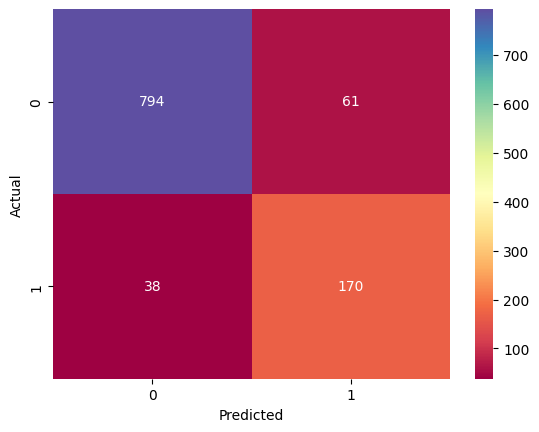

In [582]:
get_confusion_matrix(np.array(y1_test), refined_xgb_model_predict)

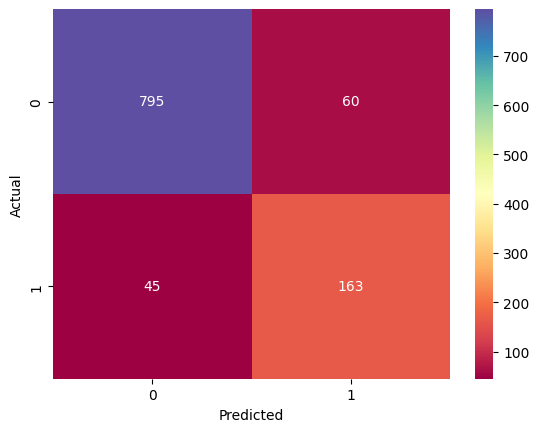

In [583]:
get_confusion_matrix(np.array(y1_test), refined_logistic_model_predict)

In [585]:
# A dictionary of model names with the various metrics
ref_xgb_log_reg_dict = {"model_name" : ["xgb.XGBClassifier", "LogisticRegression"], 
                        "accuracy"   : [accuracy_score(y1_test, refined_xgb_model_predict), accuracy_score(y1_test, refined_logistic_model_predict)], 
                        "f1_score"   : [f1_score(y1_test, refined_xgb_model_predict), f1_score(y1_test, refined_logistic_model_predict)], 
                        "recall"     : [recall_score(y1_test, refined_xgb_model_predict), recall_score(y1_test, refined_logistic_model_predict)], 
                        "precision"  : [precision_score(y1_test, refined_xgb_model_predict), precision_score(y1_test, refined_logistic_model_predict)]
                       }

# Create a dataframe with ref_xgb_log_reg_dict
ref_xgb_log_reg_df = pd.DataFrame(ref_xgb_log_reg_dict).set_index("model_name")

# Order the dataframe ref_xgb_log_reg_df by the metric values in increasing order
ref_xgb_log_reg_df.sort_values(by=["accuracy", "f1_score", "recall", "precision"], ascending=False)

,accuracy,f1_score,recall,precision
model_name,,,,
xgb.XGBClassifier,0.906867,0.774487,0.817308,0.735931
LogisticRegression,0.901223,0.756381,0.783654,0.730942
